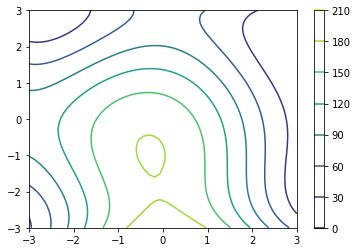

In [1]:
import os
import torch
import gpytorch
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
from botorch.models.utils import multioutput_to_batch_mode_transform

import matplotlib.pyplot as plt
import torch
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
SMOKE_TEST = os.environ.get("SMOKE_TEST")

def f(x1, x2): return (x1**2+x2-11)**2+(x1+x2**2-7)**2
x1 = np.linspace(-3, 3)
x2 = np.linspace(-3, 3)
X1, X2 = np.meshgrid(x1, x2)

plt.contour(X1, X2, f(X1, X2)+random.random(), cmap = 'viridis')
cbar = plt.colorbar()


In [2]:
torch.cuda.is_available()

False

In [3]:
tkwargs = {
    # "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "device": torch.device("cpu"),
    "dtype": torch.double,
    # "dtype": torch.float,
}

In [4]:
def smooth_mask(x, a, eps=2e-3):
    """Returns 0ish for x < a and 1ish for x > a"""
    return torch.nn.Sigmoid()((x - a) / eps)


def smooth_box_mask(x, a, b, eps=2e-3):
    """Returns 1ish for a < x < b and 0ish otherwise"""
    return smooth_mask(x, a, eps) - smooth_mask(x, b, eps)

class ExpectedCoverageImprovement(MCAcquisitionFunction):
    def __init__(
        self,
        model,
        constraints,
        punchout_radius,
        bounds,
        num_samples=512,
        **kwargs,
    ):
        """Expected Coverage Improvement (q=1 required, analytic)

        Right now, we assume that all the models in the ModelListGP have
        the same training inputs.

        Args:
            model: A ModelListGP object containing models matching the corresponding constraints.
                All models are assumed to have the same training data.
            constraints: List containing 2-tuples with (direction, value), e.g.,
                [('gt', 3), ('lt', 4)]. It is necessary that
                len(constraints) == model.num_outputs.
            punchout_radius: Positive value defining the desired minimum distance between points
            bounds: torch.tensor whose first row is the lower bounds and second row is the upper bounds
            num_samples: Number of samples for MC integration
        """
        super().__init__(model=model, objective=IdentityMCObjective(), **kwargs)
        assert len(constraints) == model.num_outputs
        assert all(direction in ("gt", "lt") for direction, _ in constraints)
        assert punchout_radius > 0
        self.constraints = constraints
        self.punchout_radius = punchout_radius
        self.bounds = bounds
        self.base_points = self.train_inputs
        self.ball_of_points = self._generate_ball_of_points(
            num_samples=num_samples,
            radius=punchout_radius,
            device=bounds.device,
            dtype=bounds.dtype,
        )
        self._thresholds = torch.tensor(
            [threshold for _, threshold in self.constraints]
        ).to(bounds)
        assert (
            all(ub > lb for lb, ub in self.bounds.T) and len(self.bounds.T) == self.dim
        )

    @property
    def num_outputs(self):
        return self.model.num_outputs

    @property
    def dim(self):
        return self.train_inputs.shape[-1]

    @property
    def train_inputs(self):
        return self.model.models[0].train_inputs[0]

    def _generate_ball_of_points(
        self, num_samples, radius, device=None, dtype=torch.double
    ):
        """Creates a ball of points to be used for MC."""
        tkwargs = {"device": device, "dtype": dtype}
        z = sample_hypersphere(d=self.dim, n=num_samples, qmc=True, **tkwargs)
        r = torch.rand(num_samples, 1, **tkwargs) ** (1 / self.dim)
        
        return radius * r * z

    def _get_base_point_mask(self, X):
        distance_matrix = self.model.models[0].covar_module.base_kernel.covar_dist(
            X, self.base_points.double()
        )   # Note: self.base_points is fp32
            # Should standardize all to fp64?
        return smooth_mask(distance_matrix, self.punchout_radius)

    def _estimate_probabilities_of_satisfaction_at_points(self, points):
        print("Estimating probabilities")
        probabilities = torch.zeros((points.shape[0:2]))
        for i in range(len(points)):
            with gpytorch.settings.fast_pred_var(), torch.no_grad():
                test_dist = self.model.models[0](points[i].float())
                pred_means = test_dist.loc
            pred_samples = test_dist.sample(torch.Size((50,))).exp()
            prob_of_one_point = (pred_samples / pred_samples.sum(-2, keepdim=True))[:,1,:].mean(0)
            probabilities[i] = prob_of_one_point
        return probabilities

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X):
        """Evaluate Expected Improvement on the candidate set X."""
        ball_around_X = self.ball_of_points + X
        domain_mask = smooth_mask(
            ball_around_X, self.bounds[0, :], self.bounds[1, :]
        ).prod(dim=-1)
        num_points_in_integral = domain_mask.sum(dim=-1)
        base_point_mask = self._get_base_point_mask(ball_around_X).prod(dim=-1)
        prob = self._estimate_probabilities_of_satisfaction_at_points(ball_around_X)
        masked_prob = prob * domain_mask * base_point_mask
        y = masked_prob.sum(dim=-1) / num_points_in_integral
        return y

In [5]:
def get_and_fit_gp(X, Y):
    # Find optimal model hyperparameters
    X = X.float()
    likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
    model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(50):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(X)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        if (i+1) % 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, 50, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()
    return model

In [6]:
def yf(x):
    v = (((x[:,0]**2+x[:,1]-11)**2+(x[:,0]+x[:,1]**2-7)**2)>160).float()
    return torch.stack((v, v), dim=-1)

In [7]:
bounds = torch.tensor([[-3, -3], [3, 3]], **tkwargs)
lb, ub = bounds
dim = len(lb)
punchout_radius = 0.6

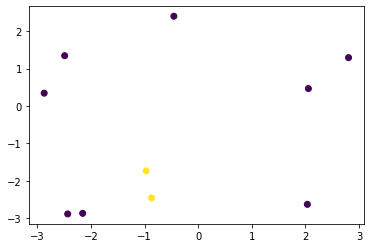

In [8]:
num_init_points = 10
num_total_points = 20 

def get_first_N_points(num):
    with open("./trainx.txt","r") as x:
        data = eval(x.read())
    train_x = torch.tensor(data)[0:num,:]
    with open("./trainy.txt","r") as y:
        data = eval(y.read())
    train_y = torch.tensor(data)[0:num]
    return train_x, train_y


X, Y = get_first_N_points(10)

X = X.double()
Y = Y.unsqueeze(-1).repeat(1,2).double()
# Convert to format usable for ECI
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=Y[:,0])


In [9]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
X = X.float()
likelihood = DirichletClassificationLikelihood(Y[:,0].long(), learn_additional_noise=True)
model = DirichletGPModel(X, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

In [10]:
constraints = [("lt", 1.01), ("gt", 0.95)]
# normalization
# mean = X.mean(dim=-2, keepdim=True)
# std = X.std(dim=-2, keepdim=True) + 1e-6 # prevent dividing by 0
# X = (X - mean) / std
# testnum = 1
'''
We need to do something about the likelihood eval
'''
while len(X) < num_total_points:
    # We don't have to normalize X since the domain is [0, 1]^2. Make sure to
    # appropriately adjust the punchout radius if the domain is normalized.
    print("Checkpoint: get_and_fit_gp")
    gp_models = get_and_fit_gp(X.float(), Y[:, 0: 1])
    model_list_gp = ModelListGP(gp_models, gp_models) # Temporary hack
    eci = ExpectedCoverageImprovement(
        model=model_list_gp,
        constraints=constraints,
        punchout_radius=punchout_radius,
        bounds=bounds,
        num_samples=512,
    )
    print("Checkpoint: x_next")
    # Switch to eval mode
    model_list_gp.models[0].eval()
    #likelihood.eval()
    x_next, _ = optimize_acqf(
        acq_function=eci,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )
    print(f"Got x_next: {x_next}")
    y_next = yf(x_next)

    X = torch.cat((X, x_next))
    Y = torch.cat((Y, y_next))
    print("Added new point to training data")

Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.237   lengthscale: 0.909   noise: 0.713
Iter 10/50 - Loss: 5.651   lengthscale: 1.164   noise: 0.786
Iter 15/50 - Loss: 5.276   lengthscale: 1.324   noise: 0.900
Iter 20/50 - Loss: 4.996   lengthscale: 1.414   noise: 1.035
Iter 25/50 - Loss: 4.821   lengthscale: 1.450   noise: 1.175
Iter 30/50 - Loss: 4.707   lengthscale: 1.436   noise: 1.310
Iter 35/50 - Loss: 4.611   lengthscale: 1.371   noise: 1.435
Iter 40/50 - Loss: 4.538   lengthscale: 1.258   noise: 1.541
Iter 45/50 - Loss: 4.470   lengthscale: 1.118   noise: 1.623
Iter 50/50 - Loss: 4.417   lengthscale: 0.979   noise: 1.677
Checkpoint: x_next
Estimating probabilities
Estimating probabilities


/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[ 0.2304, -2.1621]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.223   lengthscale: 0.912   noise: 0.713
Iter 10/50 - Loss: 5.660   lengthscale: 1.212   noise: 0.784
Iter 15/50 - Loss: 5.328   lengthscale: 1.432   noise: 0.896
Iter 20/50 - Loss: 5.110   lengthscale: 1.499   noise: 1.026
Iter 25/50 - Loss: 4.964   lengthscale: 1.451   noise: 1.158
Iter 30/50 - Loss: 4.861   lengthscale: 1.359   noise: 1.279
Iter 35/50 - Loss: 4.774   lengthscale

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[-0.2388, -1.0307]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.181   lengthscale: 0.913   noise: 0.720
Iter 10/50 - Loss: 5.601   lengthscale: 1.222   noise: 0.791
Iter 15/50 - Loss: 5.289   lengthscale: 1.474   noise: 0.895
Iter 20/50 - Loss: 5.088   lengthscale: 1.544   noise: 1.015
Iter 25/50 - Loss: 4.932   lengthscale: 1.444   noise: 1.132
Iter 30/50 - Loss: 4.823   lengthscale: 1.286   noise: 1.228
Iter 35/50 - Loss: 4.746   lengthscale: 1.165   noise: 1.292
Iter 40/50 - Loss: 4.690   lengthscale: 1.119   noise: 1.320
Iter 45/50 - Loss: 4.651   lengthscale: 1.134   noise: 1.317
Iter 50/50 - Loss: 4.620   len

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[-1.0024, -0.4158]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.165   lengthscale: 0.912   noise: 0.880
Iter 10/50 - Loss: 5.588   lengthscale: 1.223   noise: 0.967
Iter 15/50 - Loss: 5.289   lengthscale: 1.483   noise: 1.029
Iter 20/50 - Loss: 5.106   lengthscale: 1.548   noise: 1.104
Iter 25/50 - Loss: 4.946   lengthscale: 1.428   noise: 1.179
Iter 30/50 - Loss: 4.831   lengthscale: 1.249   noise: 1.235
Iter 35/50 - Loss: 4.763   lengthscale: 1.120   noise: 1.262
Iter 40/50 - Loss: 4.714   lengthscale: 1.090   noise: 1.256
Iter 45/50 - Loss: 4.672   lengthscale: 1.145   noise: 1.222
Iter 50/50 - Loss: 4.639   lengthscale: 1.230   noise: 1.162
Checkpoint: x_next


/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[0.2385, 0.1486]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.150   lengthscale: 0.913   noise: 0.905
Iter 10/50 - Loss: 5.579   lengthscale: 1.223   noise: 1.108
Iter 15/50 - Loss: 5.293   lengthscale: 1.484   noise: 1.206
Iter 20/50 - Loss: 5.132   lengthscale: 1.557   noise: 1.270
Iter 25/50 - Loss: 4.988   lengthscale: 1.449   noise: 1.313
Iter 30/50 - Loss: 4.873   lengthscale: 1.273   noise: 1.322
Iter 35/50 - Loss: 4.804   lengthscale: 1.135   noise: 1.297
Iter 40/50 - Loss: 4.759   lengthscale: 1.094   noise: 1.248
Iter 45/50 - Loss: 4.718   lengthscale: 1.144   noise: 1.179
Iter 50/50 - Loss: 4.684   lengthscale: 1.235   noise: 1.092
Checkpoint: x_next
Estimating probabilities
Es

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[ 1.0137, -0.7349]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.175   lengthscale: 0.912   noise: 0.900
Iter 10/50 - Loss: 5.642   lengthscale: 1.219   noise: 1.075
Iter 15/50 - Loss: 5.386   lengthscale: 1.456   noise: 1.188
Iter 20/50 - Loss: 5.228   lengthscale: 1.502   noise: 1.328
Iter 25/50 - Loss: 5.090   lengthscale: 1.382   noise: 1.473
Iter 30/50 - Loss: 4.984   lengthscale: 1.201   noise: 1.546
Iter 35/50 - Loss: 4.917   lengthscale: 1.051   noise: 1.539
Iter 40/50 - Loss: 4.873   lengthscale: 0.982   noise: 1.496
Iter 45/50 - Loss: 4.835   lengthscale: 0.997   noise: 1.445
Iter 50/50 - Loss: 4.805   lengthscale: 1.061   noise: 1.390
Checkpoint: x_next


/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[-2.0170, -1.0856]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.188   lengthscale: 0.912   noise: 0.882
Iter 10/50 - Loss: 5.671   lengthscale: 1.215   noise: 0.992
Iter 15/50 - Loss: 5.423   lengthscale: 1.439   noise: 1.110
Iter 20/50 - Loss: 5.264   lengthscale: 1.483   noise: 1.307
Iter 25/50 - Loss: 5.132   lengthscale: 1.379   noise: 1.521
Iter 30/50 - Loss: 5.034   lengthscale: 1.217   noise: 1.646
Iter 35/50 - Loss: 4.966   lengthscale: 1.075   noise: 1.662
Iter 40/50 - Loss: 4.916   lengthscale: 0.995   noise: 1.628
Iter 45/50 - Loss: 4.878   lengthscale: 0.976   noise: 1.585
Iter 

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[-0.7871,  0.5850]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.209   lengthscale: 0.912   noise: 0.825
Iter 10/50 - Loss: 5.701   lengthscale: 1.213   noise: 0.893
Iter 15/50 - Loss: 5.452   lengthscale: 1.442   noise: 1.042
Iter 20/50 - Loss: 5.298   lengthscale: 1.518   noise: 1.278
Iter 25/50 - Loss: 5.181   lengthscale: 1.462   noise: 1.551
Iter 30/50 - Loss: 5.097   lengthscale: 1.340   noise: 1.788
Iter 35/50 - Loss: 5.035   lengthscale: 1.213   noise: 1.912
Iter 40/50 - Loss: 4.987   lengthscale: 1.113   noise: 1.932
Iter 45/50 - Loss: 4.951   lengthscale: 1.051   noise: 1.901
Iter 

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[-0.0457, -3.0000]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.169   lengthscale: 0.912   noise: 0.894
Iter 10/50 - Loss: 5.653   lengthscale: 1.218   noise: 1.061
Iter 15/50 - Loss: 5.406   lengthscale: 1.469   noise: 1.246
Iter 20/50 - Loss: 5.266   lengthscale: 1.572   noise: 1.523
Iter 25/50 - Loss: 5.160   lengthscale: 1.534   noise: 1.833
Iter 30/50 - Loss: 5.080   lengthscale: 1.415   noise: 2.067
Iter 35/50 - Loss: 5.019   lengthscale: 1.275   noise: 2.147
Iter 40/50 - Loss: 4.974   lengthscale: 1.155   noise: 2.103
Iter 45/50 - Loss: 4.940   lengthscale: 1.078   noise: 2.000
Iter 50/50 - Loss: 4.915   lengthscale: 1.042   noise: 1.887
Checkpoint: x_next
Estimating probabilities


/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[ 1.0805, -3.0000]], dtype=torch.float64)
Added new point to training data
Checkpoint: get_and_fit_gp
Iter 5/50 - Loss: 6.156   lengthscale: 0.912   noise: 0.907
Iter 10/50 - Loss: 5.640   lengthscale: 1.221   noise: 1.178
Iter 15/50 - Loss: 5.392   lengthscale: 1.492   noise: 1.470
Iter 20/50 - Loss: 5.262   lengthscale: 1.638   noise: 1.803
Iter 25/50 - Loss: 5.173   lengthscale: 1.645   noise: 2.146
Iter 30/50 - Loss: 5.104   lengthscale: 1.556   noise: 2.436
Iter 35/50 - Loss: 5.051   lengthscale: 1.425   noise: 2.609
Iter 40/50 - Loss: 5.013   lengthscale: 1.295   noise: 2.648
Iter 45/50 - Loss: 4.987   lengthscale: 1.197   noise: 2.581
Iter 50/50 - Loss: 4.967   lengthscale: 1.141   noise: 

/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/opt/conda/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Estimating probabilities
Got x_next: tensor([[ 1.0167, -1.7377]], dtype=torch.float64)
Added new point to training data


/tmp/ipykernel_599759/3191119530.py:32: UserWarning: No contour levels were found within the data range.
  ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")


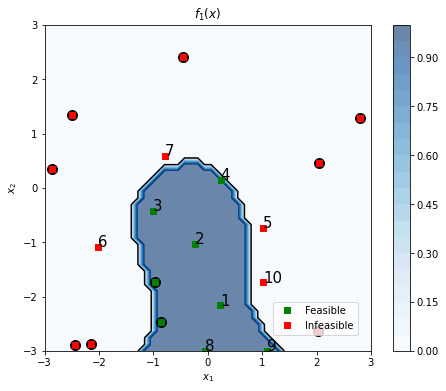

In [11]:
N1, N2 = 50, 50
Xplt, Yplt = torch.meshgrid(
    torch.linspace(-3, 3, N1, **tkwargs), torch.linspace(-3, 3, N2, **tkwargs)
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)
yplt = yf(xplt)
Zplt = torch.reshape(yplt[:, 0], (N1, N2)) 
def identify_samples_which_satisfy_constraints(X, constraints):
    """
    Takes in values (a1, ..., ak, o) and returns (a1, ..., ak, o)
    True/False values, where o is the number of outputs.
    """
    successful = torch.ones(X.shape).to(X)
    for model_index in range(X.shape[-1]):
        these_X = X[..., model_index]
        direction, value = constraints[model_index]
        successful[..., model_index] = (
            these_X < value if direction == "lt" else these_X > value
        )
    return successful


fig, ax = plt.subplots(figsize=(8, 6))
h1 = ax.contourf(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), 20, cmap="Blues", alpha=0.6)
fig.colorbar(h1)
ax.contour(Xplt.cpu(), Yplt.cpu(), Zplt.cpu(), [-10, 0], colors="k")

feasible_inds = (
    identify_samples_which_satisfy_constraints(Y, constraints)
    .prod(dim=-1)
    .to(torch.bool)
)
ax.plot(X[feasible_inds, 0].cpu(), X[feasible_inds, 1].cpu(), "sg", label="Feasible")
ax.plot(
    X[~feasible_inds, 0].cpu(), X[~feasible_inds, 1].cpu(), "sr", label="Infeasible"
)
# ax.scatter(X[:5, 0], X[:5, 1], marker = 'o', s=100, color = 'k')
ax.scatter(X.cpu()[:10, 0], X.cpu()[:10, 1], marker = 'o', s=100, color = 'k')
ind = 1
for i in X[10:]:
    plt.text(i[0],i[1],ind, size = 15)
    ind += 1
ax.legend(loc=[0.7, 0.05])
ax.set_title("$f_1(x)$")  # Recall that f1(x) = f2(x)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_aspect("equal", "box")
# ax.set_xlim([-0.05, 1.05])
# ax.set_ylim([-0.05, 1.05])
plt.show()

In [12]:
def for_plotting_only(x1, x2):
    ans = (x1**2+x2-11)**2+(x1+x2**2-7)**2
    return (ans > 160).float()

In [13]:
test_x_mat, test_y_mat = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)
test_labels = for_plotting_only(test_x_mat, test_y_mat)

In [14]:
test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

In [15]:
from_posterior = model_list_gp.models[0](test_x)

In [16]:
pred_samples = from_posterior.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

Text(0.5, 1.0, 'Probabilities')

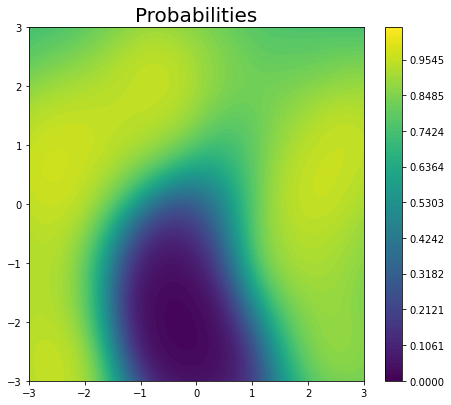

In [38]:
levels = np.linspace(0, 1.05, 100)
plt.figure(figsize=(7.5, 6.5))
plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), probabilities[0].numpy().reshape(100,100), levels=levels)
plt.colorbar()
plt.title('Probabilities', fontsize=20)


Text(0.5, 1.0, 'Estimated Boundary')

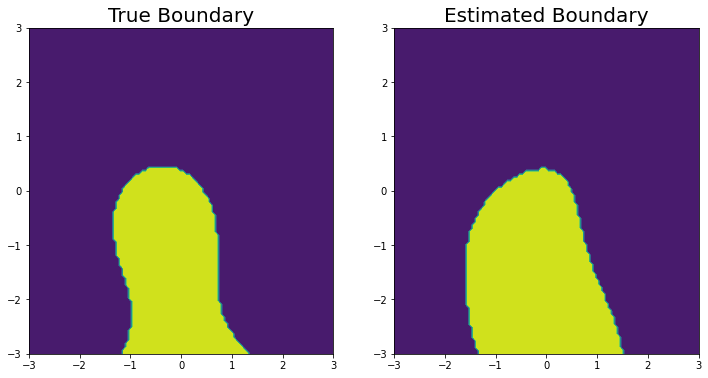

In [24]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Boundary', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), from_posterior.loc.max(0)[1].reshape((100,100)))
ax[1].set_title('Estimated Boundary', fontsize=20)